### Setup & Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *
import datetime

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk.data

from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Data

### Train Model

In [5]:
def train_model(path):
    
    # Work name
    name = path.split('/')[-2]
    
    time_start = datetime.datetime.now()
    
    # Data
    data = (TextList.from_folder(Path(path))
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=48))
    
    # Pretrained Wiki Model 
    lm = language_model_learner(data, AWD_LSTM, drop_mult=0.3)
    
    # Learning Rate via lr finder
    lr = 1e-3
    
    # For training efficiency
    lm.to_fp16();
    
    # Train last layers with high learning rate
    lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))
    
    # Train all layers for 10 epochs
    lm.unfreeze()
    lm.fit_one_cycle(10, lr, moms=(0.8,0.7))
    
    # Save weights
    lm.save('weights')
    
    # Write out update
    time_end = datetime.datetime.now()
    print(f'Took {(time_end - time_start).total_seconds() / 60 } minutes\n')
    print(f'DONE')
        
    return lm

#### Generate Sentences 

### Predict

#### Helper Functions

In [6]:
def generate_sentence(model, intro, n_words, temperature): 
    """
    Lowering temperature will make the texts less randomized.
    """
    sentence = model.predict(intro, n_words, temperature=temperature)
    return sentence.replace('\n', '')

In [7]:
def last_period(sentence):
    for i, letter in enumerate(reversed(sentence)):
        if letter == '.':
            return len(sentence) - i

In [8]:
def clean_sentence(sentence):
    sentence = sentence.replace(' ,', ',')
    sentence = sentence.replace(' ?', '?')
    sentence = sentence.replace(' .', '.')
    sentence = sentence.replace('( ', '(')
    sentence = sentence.replace(' )', ')')
    sentence = sentence.replace('“ ', '“')
    sentence = sentence.replace(" ’", "’")
    sentence = sentence.replace(" '", "'")    
    sentence = sentence.replace(" :", ":")
    sentence = sentence.replace(' ”', '”')
    sentence = sentence.replace('   ', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace(" n’t", "n’t")
    sentence = sentence.replace(' i ', ' I ')
    
    # clip to full sentence 
    return sentence[:last_period(sentence)]

#### Generate a bunch of sentences & calculate the score of each

In [9]:
def get_scored_sentences(n, model, intro, words, temperature):
    results = pd.DataFrame(columns=['sentence', 'sentiment'])
    sid = SentimentIntensityAnalyzer()
    for i in range(n):
        sentence = clean_sentence(generate_sentence(model, intro, words, temperature))
        sentiment = sid.polarity_scores(sentence)['compound']
        results.loc[i] = [sentence, sentiment]
    results.sort_values('sentiment', ascending=False, inplace=True)
    results = results.reset_index().drop('index', axis=1)
    return results

#### Generated Sentiments 

In [10]:
generated_sentences = {'anna_karenina':pd.read_csv('Sentences/anna_karenina.csv'), 
          'war_and_peace':pd.read_csv('Sentences/war_and_peace.csv'),
          'the_brothers_karamazov':pd.read_csv('Sentences/the_brothers_karamazov.csv'), 
          'crime_and_punishment':pd.read_csv('Sentences/crime_and_punishment.csv'), 
          'the_idiot':pd.read_csv('Sentences/the_idiot.csv')}

In [39]:
work = 'anna_karenina'

In [50]:
print(generated_sentences[work]['sentence'][np.random.randint(0, len(generated_sentences['crime_and_punishment']))])

In the afternoon work, half - past eight, afternoon and early, after early tea, there was an interval of still doubt, as the interval at dawn


#### Original Sentiments

In [43]:
def get_sentiment_score(path):
    
    # Load tokenizer details
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    # Create analyzer object
    analyzer = SentimentIntensityAnalyzer()
    
    # Read in data
    with open(path, 'r') as f:
        data = f.read()
        
    # Break up text into sentences
    sentences = tokenizer.tokenize(data)
    
    # Calculate average sentiment score
    scores = []
    for sentence in sentences: 
        scores.append(analyzer.polarity_scores(sentence)['compound'])
    
    return scores

In [13]:
works = ['/home/ubuntu/nlp/nlp_lit/literature/tolstoy/anna_karenina/anna_karenina.txt', 
         '/home/ubuntu/nlp/nlp_lit/literature/tolstoy/war_and_peace/war_and_peace.txt',
         '/home/ubuntu/nlp/nlp_lit/literature/dostoevsky/crime_and_punishment/crime_and_punishment.txt',
         '/home/ubuntu/nlp/nlp_lit/literature/dostoevsky/the_brothers_karamazov/the_brothers_karamazov.txt',
         '/home/ubuntu/nlp/nlp_lit/literature/dostoevsky/the_idiot/the_idiot.txt']

## Real vs. Fake

In [16]:
results = {}
for path in works: 
    work = path.split("/")[-2]
    print(f'{work}')
    real_scores = get_sentiment_score(path)
    generated_scores = generated_sentences[work]["sentiment"]
    results[work] = {'real':real_scores, 'generated':generated_scores}
    

anna_karenina
war_and_peace
crime_and_punishment
the_brothers_karamazov
the_idiot


## Plots

#### Anna Karenina

In [19]:
def real_vs_generated_dist(work, results):
    # Data
    data_real = results[work]['real']
    data_generated = results[work]['generated']

    # Density
    density_real = gaussian_kde(data_real)
    density_generated = gaussian_kde(data_generated)

    # X range
    xs = np.linspace(-1,1,200)

    # Kernel density sepecifics
    density_real.covariance_factor = lambda : .25
    density_generated.covariance_factor = lambda : .25
    density_real._compute_covariance()
    density_generated._compute_covariance()

    # Plot
    plt.plot(xs, density_real(xs), color='green')
    plt.plot(xs, density_generated(xs), color='red')
    plt.text(.5, 1.5, 'REAL', fontsize=12, color='green')
    plt.ylim(0, 2.5)
    plt.text(.5, 1.35, 'GENERATED', fontsize=12, color='red')
    plt.title(f'{work} sentiment scores')
    plt.show()

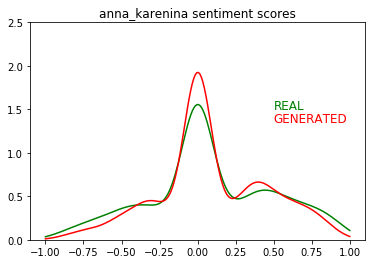

In [20]:
real_vs_generated_dist('anna_karenina', results)

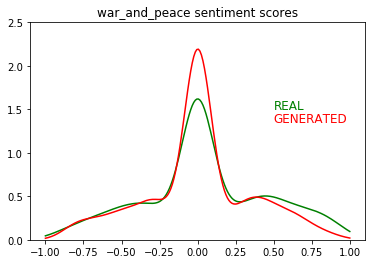

In [21]:
real_vs_generated_dist('war_and_peace', results)

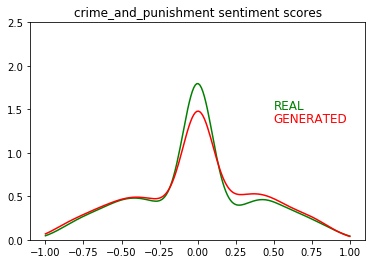

In [22]:
real_vs_generated_dist('crime_and_punishment', results)

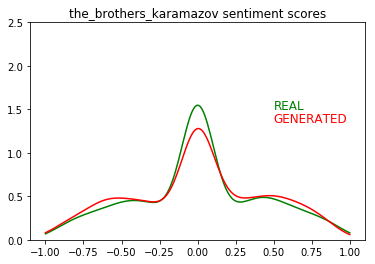

In [23]:
real_vs_generated_dist('the_brothers_karamazov', results)

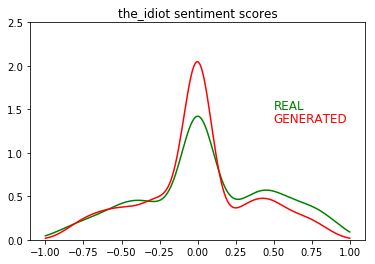

In [24]:
real_vs_generated_dist('the_idiot', results)